<a href="https://colab.research.google.com/github/DKS2301/GRU-MHA-RUL-Forecasting/blob/main/GRU_MHA_model_for_accurate_battery_RUL_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Hybrid GRU-MHA model for accurate battery RUL forecasting with feature selection**

## **IMPORTS AND SETUP**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io as sio
from scipy.io import loadmat
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import Ridge, LinearRegression
import warnings
warnings.filterwarnings('ignore')

# Deep Learning imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)


TensorFlow version: 2.19.0
GPU Available: []


## **DATA DOWNLOADING AND LOADING**

In [ ]:
print("\n" + "="*80)
print("PART 2: DATA DOWNLOADING AND LOADING")
print("="*80)

# Function to download NASA Battery Dataset
def download_nasa_dataset():
    """
    Download NASA Battery Dataset from NASA repository
    Dataset contains: B0005, B0006, B0007, B0018
    """
    import urllib.request
    import os

    nasa_urls = {
        'B0005': 'https://ti.arc.nasa.gov/c/6/',
        'B0006': 'https://ti.arc.nasa.gov/c/7/',
        'B0007': 'https://ti.arc.nasa.gov/c/8/',
        'B0018': 'https://ti.arc.nasa.gov/c/9/'
    }

    print("\nNote: NASA Battery Dataset requires manual download from:")
    print("https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/")
    print("\nPlease download the Battery Data Set (*.mat files)")
    print("Expected files: B0005.mat, B0006.mat, B0007.mat, B0018.mat")

    return nasa_urls

# Function to load NASA battery data from .mat files


def load_nasa_battery(filepath):
    """Load NASA battery file and extract complete time-series for each cycle."""

    print(f"Loading: {filepath}")
    mat = sio.loadmat(filepath, squeeze_me=True, struct_as_record=False)

    # Pick main key
    keys = [k for k in mat.keys() if not k.startswith("__")]
    root = mat[keys[0]]

    # Detect cycle structure
    cycles = None
    if hasattr(root, "cycle"):
        cycles = root.cycle
    elif "cycle" in mat:
        cycles = mat["cycle"]
    else:
        raise ValueError("Could not find cycle structure.")

    rows = []

    for idx, c in enumerate(cycles):

        data = getattr(c, "data", None)
        if data is None:
            continue

        # Extract arrays safely
        V = getattr(data, "Voltage_measured", None)
        I = getattr(data, "Current_measured", None)
        T = getattr(data, "Temperature_measured", None)
        t = getattr(data, "Time", None)
        Cap = getattr(data, "Capacity", None)

        if isinstance(Cap, np.ndarray):
            Cap = float(Cap) if Cap.size == 1 else None

        rows.append({
            "cycle_id": idx,
            "type": getattr(c, "type", None),
            "ambient_temperature": getattr(c, "ambient_temperature", None),
            "capacity": Cap,
            "V": np.array(V) if V is not None else None,
            "I": np.array(I) if I is not None else None,
            "T": np.array(T) if T is not None else None,
            "time": np.array(t) if t is not None else None,
            "length": len(t) if t is not None else 0
        })

    return pd.DataFrame(rows)

# Function to load HNEI Battery Dataset (NMC-LCO 18650)
def download_hnei_dataset():
    """
    Download HNEI Battery Dataset
    """
    print("\nNote: HNEI Battery Dataset (NMC-LCO 18650) can be downloaded from:")
    print("https://www.batteryarchive.org/")
    print("Or search for 'Hawaii Natural Energy Institute battery dataset'")
    print("\nExpected columns:")
    print("- Cycle_Index")
    print("- Discharge Time (s)")
    print("- Decrement 3.6-3.4V (s)")
    print("- Max. Voltage Dischar. (V)")
    print("- Min. Voltage Charg. (V)")
    print("- Time at 4.15V (s)")
    print("- Time constant current (s)")
    print("- Charging time (s)")
    print("- RUL")

def load_hnei_battery(file_path):
    """
    Load HNEI battery data from CSV file
    """
    try:
        df = pd.read_csv(file_path)

        print("\nHNEI Battery Dataset loaded successfully!")
        print(f"Shape: {df.shape}")
        print(f"Cycles: {len(df)}")

        return df

    except Exception as e:
        print(f"Error loading HNEI dataset: {e}")
        return None


PART 2: DATA DOWNLOADING AND LOADING


In [ ]:
def extract_nasa_features(df):
    print("\nExtracting features per cycle...")

    # Compute initial capacity (first discharge cycle)
    first_cap = df[df.type == 'discharge'].capacity.dropna().iloc[0]
    df["SoH"] = df["capacity"] / first_cap

    def flatten(series):
        # Flatten column of arrays → 1D float array
        return np.concatenate(series.values).astype(float)

    feature_df = df.groupby("cycle_id").apply(
        lambda g: pd.Series({
            "ambient_temp": g["ambient_temperature"].iloc[0],

            # Flatten arrays first
            "avg_voltage": np.mean(flatten(g["V"])),
            "avg_current": np.mean(flatten(g["I"])),
            "avg_temperature": np.mean(flatten(g["T"])),

            # Feature engineering
            "signal_energy": np.sum(flatten(g["V"])**2),
            "fluctuation": np.std(flatten(g["V"])),
            "skewness": pd.Series(flatten(g["V"])).skew(),
            "kurtosis": pd.Series(flatten(g["V"])).kurt(),

            # Target features
            "Capacity": g["capacity"].dropna().mean(),
            "SoH": g["SoH"].dropna().mean()
        })
    ).reset_index()

    print("Feature DF ready:", feature_df.columns.tolist())
    return feature_df


In [ ]:
df = load_nasa_battery("/content/data/nasa/B0005.mat")
print(df.head())


Loading: /content/data/nasa/B0005.mat
   cycle_id       type  ambient_temperature  capacity  \
0         0     charge                   24       NaN   
1         1  discharge                   24  1.856487   
2         2     charge                   24       NaN   
3         3  discharge                   24  1.846327   
4         4     charge                   24       NaN   

                                                   V  \
0  [3.873017221300996, 3.479393559379272, 4.00058...   
1  [4.191491807505295, 4.190749067776103, 3.97487...   
2  [3.3250546568448542, 3.001950570776504, 3.4346...   
3  [4.189773213846608, 4.188881380279099, 3.97915...   
4  [3.3526036599987754, 3.0358785775794024, 3.459...   

                                                   I  \
0  [-0.001200660698297908, -4.030268477538787, 1....   
1  [-0.004901589207462691, -0.0014780055516425076...   
2  [0.00030204673114322896, -3.361982908688226, 1...   
3  [2.125117981080765e-05, -0.0008794712663407272...   
4 

## **DATA PREPROCESSING AND FEATURE ENGINEERING**

In [ ]:
print("\n" + "="*80)
print("PART 3: DATA PREPROCESSING AND FEATURE ENGINEERING")
print("="*80)

def calculate_pearson_correlation(X, y):
    """
    Calculate Pearson correlation between features and target
    """
    correlations = {}

    for col in X.columns:
        x_values = X[col].values
        y_values = y.values

        # Calculate Pearson correlation
        x_mean = np.mean(x_values)
        y_mean = np.mean(y_values)

        numerator = np.sum((x_values - x_mean) * (y_values - y_mean))
        denominator = np.sqrt(np.sum((x_values - x_mean)**2) * np.sum((y_values - y_mean)**2))

        if denominator != 0:
            correlation = numerator / denominator
        else:
            correlation = 0

        correlations[col] = correlation

    return correlations

def separate_features_by_correlation(X, y, threshold=0.4):
    """
    Separate features into correlated and uncorrelated based on threshold
    Threshold: 40% (0.4) as per paper
    """
    correlations = calculate_pearson_correlation(X, y)

    correlated_features = []
    uncorrelated_features = []

    for feature, corr in correlations.items():
        if abs(corr) >= threshold:
            correlated_features.append(feature)
        else:
            uncorrelated_features.append(feature)

    print("\nFeature Separation (Threshold: 40%):")
    print(f"Correlated features ({len(correlated_features)}): {correlated_features}")
    print(f"Uncorrelated features ({len(uncorrelated_features)}): {uncorrelated_features}")
    print("\nCorrelation values:")
    for feature, corr in sorted(correlations.items(), key=lambda x: abs(x[1]), reverse=True):
        print(f"  {feature}: {corr:.4f}")

    return correlated_features, uncorrelated_features, correlations

def preprocess_data(df, target_column, feature_columns):
    """
    Preprocess data: scaling and train-test split
    """
    # Prepare features and target
    X = df[feature_columns].copy()
    y = df[target_column].copy()

    # Separate correlated and uncorrelated features
    corr_features, uncorr_features, correlations = separate_features_by_correlation(X, y)

    # Scale features
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()

    X_scaled = scaler_X.fit_transform(X)
    y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()

    # Create DataFrame with scaled values
    X_scaled_df = pd.DataFrame(X_scaled, columns=feature_columns)

    # Separate into correlated and uncorrelated
    X_corr = X_scaled_df[corr_features].values if corr_features else np.array([]).reshape(len(X_scaled_df), 0)
    X_uncorr = X_scaled_df[uncorr_features].values if uncorr_features else np.array([]).reshape(len(X_scaled_df), 0)

    return X_scaled, y_scaled, X_corr, X_uncorr, scaler_X, scaler_y, corr_features, uncorr_features, correlations



PART 3: DATA PREPROCESSING AND FEATURE ENGINEERING


## **MODEL ARCHITECTURE**

In [ ]:
print("\n" + "="*80)
print("PART 4: MODEL ARCHITECTURE")
print("="*80)

class DynamicSwish(layers.Layer):
    """
    Dynamic Swish activation function
    Formula: x / (s * (1 + e^(-x)))
    """
    def __init__(self, scale=1.0, **kwargs):
        super(DynamicSwish, self).__init__(**kwargs)
        self.scale = scale

    def call(self, x):
        return x / (self.scale * (1 + tf.exp(-x)))

    def get_config(self):
        config = super().get_config()
        config.update({"scale": self.scale})
        return config

def build_gru_mha_model(n_corr_features, n_uncorr_features, n_timesteps=1,
                        gru_units=4, mha_heads=8, dense_units=30, scale_value=1.0):
    """
    Build GRU-MHA hybrid model with dual-path architecture

    Architecture:
    1. Two parallel paths for correlated and uncorrelated features
    2. GRU layers for temporal feature extraction
    3. Multi-Head Attention for feature emphasis
    4. Dense layers for final prediction
    """

    # Input layers for correlated and uncorrelated features
    input_corr = layers.Input(shape=(n_timesteps, n_corr_features), name='correlated_input')
    input_uncorr = layers.Input(shape=(n_timesteps, n_uncorr_features), name='uncorrelated_input')

    # Path 1: Correlated features
    if n_corr_features > 0:
        # GRU layers
        gru_corr_1 = layers.GRU(gru_units, return_sequences=True, name='gru_corr_1')(input_corr)
        gru_corr_2 = layers.GRU(gru_units, return_sequences=True, name='gru_corr_2')(gru_corr_1)

        # Multi-Head Attention
        mha_corr = layers.MultiHeadAttention(
            num_heads=mha_heads,
            key_dim=gru_units,
            name='mha_corr'
        )(gru_corr_2, gru_corr_2)

        # Flatten
        flat_corr = layers.Flatten(name='flatten_corr')(mha_corr)
    else:
        flat_corr = layers.Flatten()(input_corr)

    # Path 2: Uncorrelated features
    if n_uncorr_features > 0:
        # GRU layers
        gru_uncorr_1 = layers.GRU(gru_units, return_sequences=True, name='gru_uncorr_1')(input_uncorr)
        gru_uncorr_2 = layers.GRU(gru_units, return_sequences=True, name='gru_uncorr_2')(gru_uncorr_1)

        # Multi-Head Attention
        mha_uncorr = layers.MultiHeadAttention(
            num_heads=mha_heads,
            key_dim=gru_units,
            name='mha_uncorr'
        )(gru_uncorr_2, gru_uncorr_2)

        # Flatten
        flat_uncorr = layers.Flatten(name='flatten_uncorr')(mha_uncorr)
    else:
        flat_uncorr = layers.Flatten()(input_uncorr)

    # Concatenate both paths
    if n_corr_features > 0 and n_uncorr_features > 0:
        concatenated = layers.Concatenate(name='concat')([flat_corr, flat_uncorr])
    elif n_corr_features > 0:
        concatenated = flat_corr
    else:
        concatenated = flat_uncorr

    # Dense layers
    dense_1 = layers.Dense(dense_units, activation='swish', name='dense_1')(concatenated)
    dense_2 = layers.Dense(dense_units // 2, activation='swish', name='dense_2')(dense_1)

    # Output layer with Dynamic Swish
    output = layers.Dense(1, name='output_dense')(dense_2)
    output = DynamicSwish(scale=scale_value, name='dynamic_swish')(output)

    # Create model
    model = Model(inputs=[input_corr, input_uncorr], outputs=output, name='GRU_MHA_Model')

    return model

# Baseline CNN-LSTM Model for comparison
def build_cnn_lstm_baseline(n_features, n_timesteps=1):
    """
    Build CNN-LSTM baseline model as per paper
    """
    input_layer = layers.Input(shape=(n_timesteps, n_features))

    # CNN layers
    conv1 = layers.Conv1D(filters=32, kernel_size=3, padding='same', activation='relu')(input_layer)

    # LSTM layers
    lstm1 = layers.LSTM(27, return_sequences=False)(conv1)

    # Dense layers
    dense1 = layers.Dense(30, activation='swish')(lstm1)
    output = layers.Dense(1, activation='linear')(dense1)

    model = Model(inputs=input_layer, outputs=output, name='CNN_LSTM_Baseline')

    return model



PART 4: MODEL ARCHITECTURE


## **TRAINING FUNCTIONS**

In [ ]:
print("\n" + "="*80)
print("PART 5: TRAINING FUNCTIONS")
print("="*80)

def prepare_sequences(X_corr, X_uncorr, y, n_timesteps=1):
    """
    Prepare sequences for time-series prediction
    """
    X_corr_seq = X_corr.reshape(X_corr.shape[0], n_timesteps, X_corr.shape[1])
    X_uncorr_seq = X_uncorr.reshape(X_uncorr.shape[0], n_timesteps, X_uncorr.shape[1])

    return X_corr_seq, X_uncorr_seq, y

def train_gru_mha_model(X_corr_train, X_uncorr_train, y_train,
                        X_corr_val, X_uncorr_val, y_val,
                        scale_value=1.0, epochs=250, batch_size=32):
    """
    Train GRU-MHA model with callbacks
    """
    n_corr_features = X_corr_train.shape[2]
    n_uncorr_features = X_uncorr_train.shape[2]

    # Build model
    model = build_gru_mha_model(
        n_corr_features=n_corr_features,
        n_uncorr_features=n_uncorr_features,
        scale_value=scale_value
    )

    # Compile model with Nadam optimizer (learning rate = 0.001)
    model.compile(
        optimizer=Nadam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )

    print("\nModel Summary:")
    model.summary()

    # Callbacks
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=50,
        restore_best_weights=True,
        verbose=1
    )

    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.3,
        patience=50,
        min_lr=1e-7,
        verbose=1
    )

    # Train model
    print("\nTraining model...")
    history = model.fit(
        [X_corr_train, X_uncorr_train],
        y_train,
        validation_data=([X_corr_val, X_uncorr_val], y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )

    return model, history

def apply_ridge_regression(model, X_corr_train, X_uncorr_train, y_train,
                           X_corr_test, X_uncorr_test, alpha=1.5):
    """
    Apply Ridge regression as final forecasting layer
    """
    # Get features from trained model (before output layer)
    feature_extractor = Model(
        inputs=model.input,
        outputs=model.layers[-3].output  # Get output before final dense layers
    )

    # Extract features
    train_features = feature_extractor.predict([X_corr_train, X_uncorr_train], verbose=0)
    test_features = feature_extractor.predict([X_corr_test, X_uncorr_test], verbose=0)

    # Train Ridge regression
    ridge = Ridge(alpha=alpha, solver='cholesky')
    ridge.fit(train_features, y_train)

    # Predict
    y_pred_train = ridge.predict(train_features)
    y_pred_test = ridge.predict(test_features)

    return y_pred_train, y_pred_test, ridge


PART 5: TRAINING FUNCTIONS


# **EVALUATION AND VISUALIZATION**

In [ ]:
print("\n" + "="*80)
print("PART 6: EVALUATION AND VISUALIZATION")
print("="*80)

def evaluate_model(y_true, y_pred, scaler_y, dataset_name="Dataset"):
    """
    Evaluate model performance with multiple metrics
    """
    # Inverse transform predictions
    y_true_original = scaler_y.inverse_transform(y_true.reshape(-1, 1)).flatten()
    y_pred_original = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten()

    # Calculate metrics
    mae = mean_absolute_error(y_true_original, y_pred_original)
    mse = mean_squared_error(y_true_original, y_pred_original)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true_original, y_pred_original)

    print(f"\n{'='*60}")
    print(f"Evaluation Results - {dataset_name}")
    print(f"{'='*60}")
    print(f"MAE:   {mae:.6f}")
    print(f"MSE:   {mse:.6f}")
    print(f"RMSE:  {rmse:.6f}")
    print(f"R² Score: {r2*100:.2f}%")
    print(f"{'='*60}\n")

    return {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R2': r2
    }

def plot_training_history(history, dataset_name="Dataset"):
    """
    Plot training history
    """
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Loss plot
    axes[0].plot(history.history['loss'], label='Training Loss', linewidth=2)
    axes[0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Loss (MSE)', fontsize=12)
    axes[0].set_title(f'Model Loss - {dataset_name}', fontsize=14, fontweight='bold')
    axes[0].legend(fontsize=10)
    axes[0].grid(True, alpha=0.3)

    # MAE plot
    axes[1].plot(history.history['mae'], label='Training MAE', linewidth=2)
    axes[1].plot(history.history['val_mae'], label='Validation MAE', linewidth=2)
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('MAE', fontsize=12)
    axes[1].set_title(f'Model MAE - {dataset_name}', fontsize=14, fontweight='bold')
    axes[1].legend(fontsize=10)
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def plot_predictions(y_true, y_pred, scaler_y, dataset_name="Dataset"):
    """
    Plot actual vs predicted values
    """
    # Inverse transform
    y_true_original = scaler_y.inverse_transform(y_true.reshape(-1, 1)).flatten()
    y_pred_original = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten()

    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Time series plot
    axes[0].plot(y_true_original, label='Actual', linewidth=2, marker='o', markersize=4)
    axes[0].plot(y_pred_original, label='Predicted', linewidth=2, marker='s', markersize=4)
    axes[0].set_xlabel('Sample Index', fontsize=12)
    axes[0].set_ylabel('Value', fontsize=12)
    axes[0].set_title(f'Actual vs Predicted - {dataset_name}', fontsize=14, fontweight='bold')
    axes[0].legend(fontsize=10)
    axes[0].grid(True, alpha=0.3)

    # Scatter plot
    axes[1].scatter(y_true_original, y_pred_original, alpha=0.6, s=50)

    # Perfect prediction line
    min_val = min(y_true_original.min(), y_pred_original.min())
    max_val = max(y_true_original.max(), y_pred_original.max())
    axes[1].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')

    axes[1].set_xlabel('Actual Value', fontsize=12)
    axes[1].set_ylabel('Predicted Value', fontsize=12)
    axes[1].set_title(f'Prediction Scatter - {dataset_name}', fontsize=14, fontweight='bold')
    axes[1].legend(fontsize=10)
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def plot_correlation_heatmap(df, feature_columns, target_column):
    """
    Plot correlation heatmap
    """
    # Calculate correlation matrix
    corr_data = df[feature_columns + [target_column]]
    corr_matrix = corr_data.corr()

    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm',
                center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
    plt.title('Feature Correlation Heatmap', fontsize=16, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()

def plot_feature_importance(correlations, dataset_name="Dataset"):
    """
    Plot feature importance based on Pearson correlation
    """
    features = list(correlations.keys())
    values = [abs(v) for v in correlations.values()]

    # Sort by absolute correlation
    sorted_idx = np.argsort(values)[::-1]
    features_sorted = [features[i] for i in sorted_idx]
    values_sorted = [values[i] for i in sorted_idx]

    plt.figure(figsize=(12, 6))
    bars = plt.barh(features_sorted, values_sorted)

    # Color bars based on threshold
    colors = ['green' if v >= 0.4 else 'orange' for v in values_sorted]
    for bar, color in zip(bars, colors):
        bar.set_color(color)

    plt.xlabel('Absolute Pearson Correlation', fontsize=12)
    plt.ylabel('Features', fontsize=12)
    plt.title(f'Feature Importance - {dataset_name}', fontsize=14, fontweight='bold')
    plt.axvline(x=0.4, color='red', linestyle='--', linewidth=2, label='Threshold (0.4)')
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3, axis='x')
    plt.tight_layout()
    plt.show()


PART 6: EVALUATION AND VISUALIZATION


## **COMPLETE PIPELINE EXECUTION**

In [ ]:
print("\n" + "="*80)
print("PART 7: COMPLETE PIPELINE")
print("="*80)

def run_complete_pipeline(df, target_column, feature_columns, dataset_name,
                          test_size=0.2, scale_value=1.0, alpha=1.5):
    """
    Run complete training and evaluation pipeline
    """
    print(f"\n{'='*80}")
    print(f"Running Pipeline for: {dataset_name}")
    print(f"{'='*80}")

    # 1. Data Preprocessing
    print("\n[1/7] Preprocessing data...")
    X_scaled, y_scaled, X_corr, X_uncorr, scaler_X, scaler_y, corr_features, uncorr_features, correlations = \
        preprocess_data(df, target_column, feature_columns)

    # 2. Visualizations
    print("\n[2/7] Creating visualizations...")
    plot_correlation_heatmap(df, feature_columns, target_column)
    plot_feature_importance(correlations, dataset_name)

    # 3. Train-test split
    print("\n[3/7] Splitting data...")
    if X_corr.shape[1] > 0 and X_uncorr.shape[1] > 0:
        X_corr_train, X_corr_test, X_uncorr_train, X_uncorr_test, y_train, y_test = \
            train_test_split(X_corr, X_uncorr, y_scaled, test_size=test_size, shuffle=False)
    elif X_corr.shape[1] > 0:
        X_corr_train, X_corr_test, y_train, y_test = \
            train_test_split(X_corr, y_scaled, test_size=test_size, shuffle=False)
        X_uncorr_train = np.zeros((len(X_corr_train), 1))
        X_uncorr_test = np.zeros((len(X_corr_test), 1))
    else:
        X_uncorr_train, X_uncorr_test, y_train, y_test = \
            train_test_split(X_uncorr, y_scaled, test_size=test_size, shuffle=False)
        X_corr_train = np.zeros((len(X_uncorr_train), 1))
        X_corr_test = np.zeros((len(X_uncorr_test), 1))

    # 4. Prepare sequences
    print("\n[4/7] Preparing sequences...")
    X_corr_train_seq, X_uncorr_train_seq, y_train = prepare_sequences(X_corr_train, X_uncorr_train, y_train)
    X_corr_test_seq, X_uncorr_test_seq, y_test = prepare_sequences(X_corr_test, X_uncorr_test, y_test)

    # 5. Train model
    print("\n[5/7] Training GRU-MHA model...")
    model, history = train_gru_mha_model(
        X_corr_train_seq, X_uncorr_train_seq, y_train,
        X_corr_test_seq, X_uncorr_test_seq, y_test,
        scale_value=scale_value
    )

    plot_training_history(history, dataset_name)

    # 6. Apply Ridge Regression
    print("\n[6/7] Applying Ridge regression...")
    y_pred_train, y_pred_test, ridge_model = apply_ridge_regression(
        model, X_corr_train_seq, X_uncorr_train_seq, y_train,
        X_corr_test_seq, X_uncorr_test_seq, alpha=alpha
    )

    # 7. Evaluate
    print("\n[7/7] Evaluating model...")
    train_metrics = evaluate_model(y_train, y_pred_train, scaler_y, f"{dataset_name} - Training")
    test_metrics = evaluate_model(y_test, y_pred_test, scaler_y, f"{dataset_name} - Testing")

    # Plot predictions
    plot_predictions(y_test, y_pred_test, scaler_y, dataset_name)

    results = {
        'model': model,
        'ridge': ridge_model,
        'history': history,
        'train_metrics': train_metrics,
        'test_metrics': test_metrics,
        'scaler_X': scaler_X,
        'scaler_y': scaler_y,
        'corr_features': corr_features,
        'uncorr_features': uncorr_features
    }

    return results


PART 7: COMPLETE PIPELINE


## **DATASET-SPECIFIC IMPLEMENTATIONS**

In [ ]:

print("\n" + "="*80)
print("PART 8: DATASET-SPECIFIC IMPLEMENTATIONS")
print("="*80)



PART 8: DATASET-SPECIFIC IMPLEMENTATIONS


## **NASA BATTERY DATASET**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import scipy.stats as stats

def process_nasa_battery(file_path, battery_name='B0005'):
    """
    Fully robust NASA battery processing pipeline.
    - Handles different dataset column names
    - Computes all required features
    - Ensures all features are scalar and aligned
    - Runs DRDC-RoPE pipeline without KeyError or broadcast errors
    """
    print(f"\n{'='*80}")
    print(f"Processing NASA Battery: {battery_name}")
    print(f"{'='*80}")

    # Load NASA file
    df = load_nasa_battery(file_path)
    if df is None or df.empty:
        print(f"❌ Failed to load {battery_name}")
        return None

    # Keep only discharge cycles
    df_dis = df[df["type"] == "discharge"].reset_index(drop=True)
    if len(df_dis) == 0:
        print("❌ No discharge cycles found → Cannot compute SoH.")
        return None

    # Compute SoH
    capacity_col = "Capacity" if "Capacity" in df_dis.columns else "capacity"
    initial_capacity = df_dis[capacity_col].max()
    df_dis["SoH"] = df_dis[capacity_col] / initial_capacity
    print(f"Initial Capacity = {initial_capacity:.4f} Ah")
    print(f"Discharge cycles: {len(df_dis)}")

    # -----------------------------
    # 🔹 Column renaming for pipeline
    # -----------------------------
    column_map = {
        "Cycle": "cycle_id",
        "cycle_id": "cycle_id",
        "Voltage_Measured": "V",
        "V": "V",
        "Current_Measured": "I",
        "I": "I",
        "Temperature_Measured": "T",
        "T": "T",
        "Capacity": "capacity",
        "capacity": "capacity",
        "Signal_Energy": "signal_energy",
        "Fluctuation_Index": "fluctuation",
        "Skewness_Index": "skewness",
        "Kurtosis_Index": "kurtosis",
        "ambient_temperature": "ambient_temp"
    }

    df_dis.rename(columns={k:v for k,v in column_map.items() if k in df_dis.columns}, inplace=True)

    # -----------------------------
    # 🔹 Ensure all scalar features exist
    # -----------------------------
    required_features = [
        "cycle_id", "ambient_temp", "avg_voltage", "avg_current", "avg_temperature",
        "capacity", "signal_energy", "fluctuation", "skewness", "kurtosis"
    ]

    # Default ambient temperature
    if "ambient_temp" not in df_dis.columns:
        df_dis["ambient_temp"] = 25

    # Compute scalar features from arrays
    feature_map = {
        "avg_voltage": "V",
        "avg_current": "I",
        "avg_temperature": "T",
        "signal_energy": "V",
        "fluctuation": "V",
        "skewness": "V",
        "kurtosis": "V"
    }

    for feat, arr_col in feature_map.items():
        if feat not in df_dis.columns:
            if arr_col in df_dis.columns:
                if feat in ["avg_voltage", "avg_current", "avg_temperature"]:
                    df_dis[feat] = df_dis[arr_col].apply(
                        lambda x: np.mean(x) if isinstance(x, (list, np.ndarray)) and len(x) > 0 else 0
                    )
                else:  # statistical features
                    df_dis[feat] = df_dis[arr_col].apply(
                        lambda x: (
                            np.sum(np.square(x)) if feat=="signal_energy" else
                            np.std(x) if feat=="fluctuation" else
                            stats.skew(x) if feat=="skewness" else
                            stats.kurtosis(x)
                        ) if isinstance(x, (list, np.ndarray)) and len(x) > 0 else 0
                    )
            else:
                df_dis[feat] = 0

    # -----------------------------
    # 🔹 Dataset info & visualization
    # -----------------------------
    print("\nDataset Info:")
    print(df_dis.info())
    print("\nFirst few rows:")
    print(df_dis.head())
    print("\nStatistical Summary:")
    print(df_dis.describe())

    plt.figure(figsize=(12, 6))
    plt.plot(df_dis["cycle_id"], df_dis["SoH"], marker='o', markersize=4, linewidth=2)
    plt.xlabel("Cycle Number")
    plt.ylabel("State of Health (SoH)")
    plt.title(f"Battery Capacity Degradation - {battery_name}")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # -----------------------------
    # 🔹 Run complete pipeline
    # -----------------------------
    results = run_complete_pipeline(
        df=df_dis,
        target_column="SoH",
        feature_columns=required_features,
        dataset_name=f'NASA {battery_name}',
        test_size=0.2,
        scale_value=8.0,
        alpha=1.5
    )

    return results


## **HNEI BATTERY DATASET**

In [ ]:
def process_hnei_battery(file_path):
    """
    Complete processing pipeline for HNEI battery dataset
    """
    print(f"\n{'='*80}")
    print(f"Processing HNEI Battery (NMC-LCO 18650)")
    print(f"{'='*80}")

    # Load data
    df = load_hnei_battery(file_path)

    if df is None:
        print("Failed to load HNEI dataset")
        return None

    # Define features for HNEI dataset
    feature_columns = [
        'Cycle_Index',
        'Discharge Time (s)',
        'Decrement 3.6-3.4V (s)',
        'Max. Voltage Dischar. (V)',
        'Min. Voltage Charg. (V)',
        'Time at 4.15V (s)',
        'Time constant current (s)',
        'Charging time (s)'
    ]

    target_column = 'RUL'

    # Display dataset info
    print("\nDataset Info:")
    print(df.info())
    print("\nFirst few rows:")
    print(df.head())
    print("\nStatistical Summary:")
    print(df.describe())

    # Plot RUL vs Cycle
    plt.figure(figsize=(12, 6))
    plt.plot(df['Cycle_Index'], df['RUL'], linewidth=2, marker='o', markersize=3)
    plt.xlabel('Cycle Index', fontsize=12)
    plt.ylabel('Remaining Useful Life (RUL)', fontsize=12)
    plt.title('Battery RUL Degradation - NMC-LCO 18650', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Run pipeline with scale_value appropriate for HNEI (100s range)
    results = run_complete_pipeline(
        df=df,
        target_column=target_column,
        feature_columns=feature_columns,
        dataset_name='HNEI NMC-LCO 18650',
        test_size=0.2,
        scale_value=1.0,  # As per paper for 100s range
        alpha=1.5
    )

    return results

## **COMPARISON WITH BASELINE AND ML MODELS**

In [ ]:
print("\n" + "="*80)
print("PART 9: MODEL COMPARISON")
print("="*80)

from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

def compare_with_baselines(df, target_column, feature_columns, dataset_name):
    """
    Compare GRU-MHA with baseline models
    """
    print(f"\n{'='*80}")
    print(f"Comparing Models on: {dataset_name}")
    print(f"{'='*80}")

    # Preprocess data
    X_scaled, y_scaled, X_corr, X_uncorr, scaler_X, scaler_y, _, _, _ = \
        preprocess_data(df, target_column, feature_columns)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y_scaled, test_size=0.2, shuffle=False
    )

    results_dict = {}

    # 1. K-Nearest Neighbors Regression
    print("\n[1/4] Training KNN Regression...")
    knn = KNeighborsRegressor(n_neighbors=5)
    knn.fit(X_train, y_train)
    y_pred_knn = knn.predict(X_test)
    results_dict['KNN'] = evaluate_model(y_test, y_pred_knn, scaler_y, f"{dataset_name} - KNN")

    # 2. Support Vector Regression
    print("\n[2/4] Training SVR...")
    svr = SVR(kernel='rbf', C=100, gamma=0.1)
    svr.fit(X_train, y_train)
    y_pred_svr = svr.predict(X_test)
    results_dict['SVR'] = evaluate_model(y_test, y_pred_svr, scaler_y, f"{dataset_name} - SVR")

    # 3. Random Forest Regression
    print("\n[3/4] Training Random Forest...")
    rf = RandomForestRegressor(n_estimators=150, max_depth=10, min_samples_leaf=4, random_state=42)
    rf.fit(X_train, y_train)
    y_pred_rf = rf.predict(X_test)
    results_dict['RF'] = evaluate_model(y_test, y_pred_rf, scaler_y, f"{dataset_name} - RF")

    # 4. CNN-LSTM Baseline
    print("\n[4/4] Training CNN-LSTM Baseline...")
    X_train_seq = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
    X_test_seq = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

    baseline_model = build_cnn_lstm_baseline(X_train.shape[1])
    baseline_model.compile(optimizer=Nadam(learning_rate=0.001), loss='mse', metrics=['mae'])

    history_baseline = baseline_model.fit(
        X_train_seq, y_train,
        validation_data=(X_test_seq, y_test),
        epochs=100,
        batch_size=32,
        verbose=0,
        callbacks=[EarlyStopping(patience=20, restore_best_weights=True)]
    )

    y_pred_cnn_lstm = baseline_model.predict(X_test_seq, verbose=0).flatten()
    results_dict['CNN-LSTM'] = evaluate_model(y_test, y_pred_cnn_lstm, scaler_y, f"{dataset_name} - CNN-LSTM")

    # Create comparison table
    print(f"\n{'='*80}")
    print(f"COMPARISON SUMMARY - {dataset_name}")
    print(f"{'='*80}")
    print(f"{'Model':<15} {'MAE':<12} {'MSE':<12} {'RMSE':<12} {'R² Score':<12}")
    print(f"{'-'*80}")

    for model_name, metrics in results_dict.items():
        print(f"{model_name:<15} {metrics['MAE']:<12.6f} {metrics['MSE']:<12.6f} "
              f"{metrics['RMSE']:<12.6f} {metrics['R2']*100:<11.2f}%")

    print(f"{'='*80}\n")

    return results_dict



PART 9: MODEL COMPARISON


## **FORWARD FEATURE SELECTION**

In [ ]:
print("\n" + "="*80)
print("PART 10: FEATURE SELECTION ANALYSIS")
print("="*80)

def forward_feature_selection(df, target_column, feature_columns, dataset_name):
    """
    Perform forward feature selection analysis
    """
    print(f"\n{'='*80}")
    print(f"Forward Feature Selection: {dataset_name}")
    print(f"{'='*80}")

    from sklearn.preprocessing import StandardScaler
    from sklearn.linear_model import LinearRegression

    X = df[feature_columns]
    y = df[target_column]

    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    selected_features = []
    remaining_features = feature_columns.copy()
    r2_scores = []

    while remaining_features:
        best_r2 = -np.inf
        best_feature = None

        for feature in remaining_features:
            test_features = selected_features + [feature]
            feature_indices = [feature_columns.index(f) for f in test_features]

            X_subset = X_scaled[:, feature_indices]

            # Train-test split
            X_train, X_test, y_train, y_test = train_test_split(
                X_subset, y, test_size=0.2, shuffle=False
            )

            # Train simple linear regression
            lr = LinearRegression()
            lr.fit(X_train, y_train)
            y_pred = lr.predict(X_test)

            r2 = r2_score(y_test, y_pred)

            if r2 > best_r2:
                best_r2 = r2
                best_feature = feature

        selected_features.append(best_feature)
        remaining_features.remove(best_feature)
        r2_scores.append(best_r2)

        print(f"Added: {best_feature:<30} R² Score: {best_r2:.4f}")

    # Plot feature selection results
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, len(selected_features) + 1), r2_scores, marker='o', linewidth=2, markersize=8)
    plt.xlabel('Number of Features', fontsize=12)
    plt.ylabel('R² Score', fontsize=12)
    plt.title(f'Forward Feature Selection - {dataset_name}', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.xticks(range(1, len(selected_features) + 1))

    # Annotate feature names
    for i, (feature, r2) in enumerate(zip(selected_features, r2_scores)):
        if i % 2 == 0:  # Annotate every other point to avoid crowding
            plt.annotate(feature, xy=(i+1, r2), xytext=(5, 5),
                        textcoords='offset points', fontsize=8)

    plt.tight_layout()
    plt.show()

    return selected_features, r2_scores



PART 10: FEATURE SELECTION ANALYSIS


## **MAIN EXECUTION**

In [ ]:
!ls data/nasa

B0005.mat  B0006.mat  B0007.mat  B0018.mat


In [ ]:
print("\n" + "="*80)
print("PART 11: MAIN EXECUTION")
print("="*80)

def main():
    """
    Main execution function
    """
    print("\n" + "="*80)
    print("BATTERY RUL/SOH PREDICTION - COMPLETE IMPLEMENTATION")
    print("Based on: Aljohani & Aljohani (2025)")
    print("="*80)

    # ========================================================================
    # OPTION 1: Process NASA Battery Dataset
    # ========================================================================
    print("\n" + "="*80)
    print("OPTION 1: NASA BATTERY DATASET")
    print("="*80)

    nasa_file_path = 'data/nasa/B0005.mat'  # UPDATE THIS PATH

    #Process NASA B0005
    nasa_results_b0005 = process_nasa_battery(nasa_file_path, 'B0005')

    #Compare with baselines
    comparison_results_nasa = compare_with_baselines(
        df=load_nasa_battery(nasa_file_path),
        target_column='SoH',
        feature_columns=[
            'Cycle',
            'Time_Measured',
            'Voltage_Measured',
            'Current_Measured',
            'Temperature_Measured',
            'Capacity',
            'Signal_Energy',
            'Fluctuation_Index',
            'Skewness_Index',
            'Kurtosis_Index'
        ],
        dataset_name='NASA B0005'
    )


    #Feature selection analysis
    selected_features_nasa, r2_scores_nasa = forward_feature_selection(
        df=load_nasa_battery(nasa_file_path),
        target_column='SoH',
        feature_columns=[
            'Cycle',
            'Time_Measured',
            'Voltage_Measured',
            'Current_Measured',
            'Temperature_Measured',
            'Capacity',
            'Signal_Energy',
            'Fluctuation_Index',
            'Skewness_Index',
            'Kurtosis_Index'
        ],
        dataset_name='NASA B0005'
    )

    print("\nTo process NASA battery data:")
    print("1. Download datasets from: https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/")
    print("2. Update nasa_file_path variable with your file path")
    print("3. Uncomment the following lines:")
    print()
    print("# Process NASA B0005")
    print("# nasa_results_b0005 = process_nasa_battery(nasa_file_path, 'B0005')")
    print()
    print("# Compare with baselines")
    print("# comparison_results_nasa = compare_with_baselines(")
    print("#     df=load_nasa_battery(nasa_file_path, 'B0005'),")
    print("#     target_column='SoH',")
    print("#     feature_columns=['Cycle', 'Time_Measured', 'Voltage_Measured', ...]")
    print("#     dataset_name='NASA B0005'")
    print("# )")
    print()
    print("# Feature selection analysis")
    print("# selected_features_nasa, r2_scores_nasa = forward_feature_selection(")
    print("#     df=load_nasa_battery(nasa_file_path, 'B0005'),")
    print("#     target_column='SoH',")
    print("#     feature_columns=[...],")
    print("#     dataset_name='NASA B0005'")
    print("# )")

    # ========================================================================
    # OPTION 2: Process HNEI Battery Dataset
    # ========================================================================
    print("\n" + "="*80)
    print("OPTION 2: HNEI BATTERY DATASET (NMC-LCO 18650)")
    print("="*80)

    hnei_file_path = 'path/to/hnei_battery.csv'  # UPDATE THIS PATH

    print("\nTo process HNEI battery data:")
    print("1. Download dataset from: https://www.batteryarchive.org/")
    print("2. Update hnei_file_path variable with your file path")
    print("3. Uncomment the following lines:")
    print()
    print("# Process HNEI Battery")
    print("# hnei_results = process_hnei_battery(hnei_file_path)")
    print()
    print("# Compare with baselines")
    print("# comparison_results_hnei = compare_with_baselines(")
    print("#     df=load_hnei_battery(hnei_file_path),")
    print("#     target_column='RUL',")
    print("#     feature_columns=['Cycle_Index', 'Discharge Time (s)', ...]")
    print("#     dataset_name='HNEI NMC-LCO 18650'")
    print("# )")
    print()
    print("# Feature selection analysis")
    print("# selected_features_hnei, r2_scores_hnei = forward_feature_selection(")
    print("#     df=load_hnei_battery(hnei_file_path),")
    print("#     target_column='RUL',")
    print("#     feature_columns=[...],")
    print("#     dataset_name='HNEI NMC-LCO 18650'")
    print("# )")

    # ========================================================================
    # DEMO WITH SYNTHETIC DATA (for testing without real datasets)
    # ========================================================================
    # print("\n" + "="*80)
    # print("DEMO: SYNTHETIC DATA (for testing code structure)")
    # print("="*80)
    # print("\nCreating synthetic battery degradation data for demonstration...")

    # # Create synthetic data mimicking battery degradation
    # n_cycles = 168
    # cycles = np.arange(1, n_cycles + 1)

    # # Simulate capacity degradation (exponential decay with noise)
    # initial_capacity = 2.0
    # decay_rate = 0.003
    # capacity = initial_capacity * np.exp(-decay_rate * cycles) + np.random.normal(0, 0.01, n_cycles)

    # # Calculate SoH
    # soh = capacity / initial_capacity

    # # Generate synthetic features
    # synthetic_df = pd.DataFrame({
    #     'Cycle': cycles,
    #     'Time_Measured': 1800 + np.random.normal(0, 50, n_cycles),
    #     'Voltage_Measured': 3.7 - 0.001 * cycles + np.random.normal(0, 0.05, n_cycles),
    #     'Current_Measured': 1.5 + np.random.normal(0, 0.1, n_cycles),
    #     'Temperature_Measured': 25 + np.random.normal(0, 2, n_cycles),
    #     'Capacity': capacity,
    #     'Signal_Energy': 1000 - 2 * cycles + np.random.normal(0, 20, n_cycles),
    #     'Fluctuation_Index': 0.1 + 0.001 * cycles + np.random.normal(0, 0.01, n_cycles),
    #     'Skewness_Index': np.random.normal(0, 0.5, n_cycles),
    #     'Kurtosis_Index': np.random.normal(3, 0.5, n_cycles),
    #     'SoH': soh
    # })

    # print("\nSynthetic dataset created!")
    # print(f"Shape: {synthetic_df.shape}")
    # print("\nFirst few rows:")
    # print(synthetic_df.head())

    # # Define features
    # feature_columns_demo = [
    #     'Cycle', 'Time_Measured', 'Voltage_Measured', 'Current_Measured',
    #     'Temperature_Measured', 'Capacity', 'Signal_Energy',
    #     'Fluctuation_Index', 'Skewness_Index', 'Kurtosis_Index'
    # ]

    # # Run demo pipeline
    # print("\nRunning demo pipeline with synthetic data...")
    # demo_results = run_complete_pipeline(
    #     df=synthetic_df,
    #     target_column='SoH',
    #     feature_columns=feature_columns_demo,
    #     dataset_name='Synthetic Battery Demo',
    #     test_size=0.2,
    #     scale_value=8.0,
    #     alpha=1.5
    # )

    # # Compare with baselines
    # print("\nComparing with baseline models...")
    # demo_comparison = compare_with_baselines(
    #     df=synthetic_df,
    #     target_column='SoH',
    #     feature_columns=feature_columns_demo,
    #     dataset_name='Synthetic Battery Demo'
    # )

    # # Feature selection
    # print("\nPerforming feature selection analysis...")
    # demo_features, demo_r2 = forward_feature_selection(
    #     df=synthetic_df,
    #     target_column='SoH',
    #     feature_columns=feature_columns_demo,
    #     dataset_name='Synthetic Battery Demo'
    # )

    # print("\n" + "="*80)
    # print("DEMO COMPLETE!")
    # print("="*80)
    # print("\nTo use with real datasets:")
    # print("1. Download NASA battery datasets (.mat files)")
    # print("2. Download HNEI battery dataset (.csv file)")
    # print("3. Update file paths in the code")
    # print("4. Uncomment the appropriate sections")
    # print("="*80)

    # return demo_results, demo_comparison


PART 11: MAIN EXECUTION



Starting battery RUL/SoH prediction implementation...
This may take several minutes depending on your hardware.



BATTERY RUL/SOH PREDICTION - COMPLETE IMPLEMENTATION
Based on: Aljohani & Aljohani (2025)

OPTION 1: NASA BATTERY DATASET

Processing NASA Battery: B0005
Loading: data/nasa/B0005.mat
Initial Capacity = 1.8565 Ah
Discharge cycles: 168

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168 entries, 0 to 167
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   cycle_id         168 non-null    int64  
 1   type             168 non-null    object 
 2   ambient_temp     168 non-null    int64  
 3   capacity         168 non-null    float64
 4   V                168 non-null    object 
 5   I                168 non-null    object 
 6   T                168 non-null    object 
 7   time             168 non-null    object 
 8   length           168 non-null    int64  
 9   SoH              16

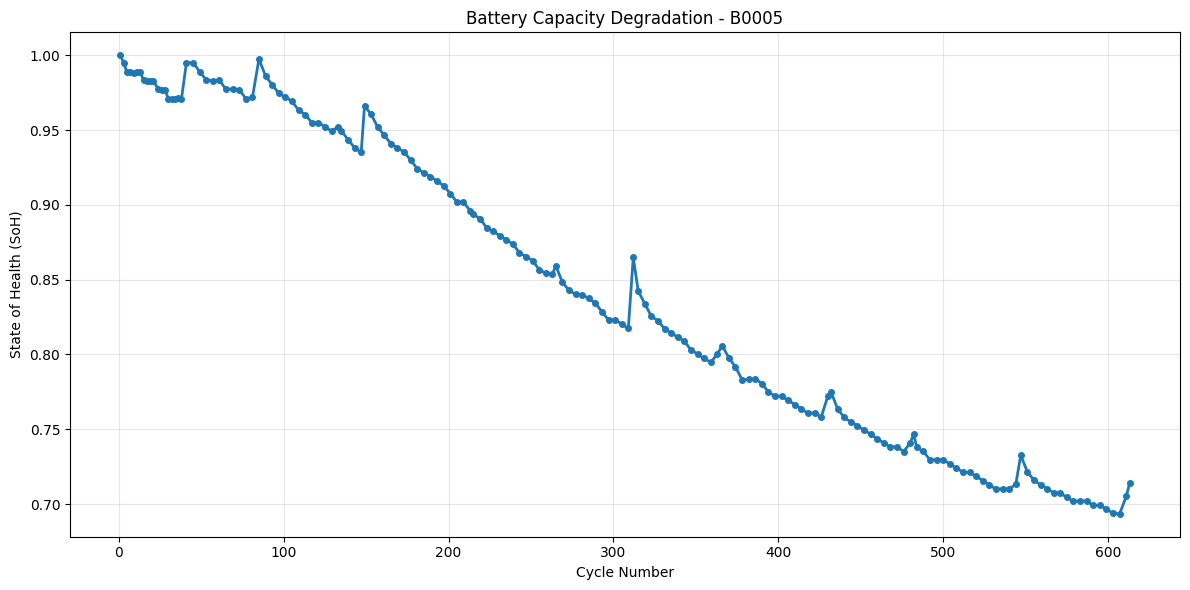


Running Pipeline for: NASA B0005

[1/7] Preprocessing data...

Feature Separation (Threshold: 40%):
Correlated features (7): ['cycle_id', 'avg_voltage', 'avg_current', 'avg_temperature', 'capacity', 'skewness', 'kurtosis']
Uncorrelated features (3): ['ambient_temp', 'signal_energy', 'fluctuation']

Correlation values:
  capacity: 1.0000
  cycle_id: -0.9895
  avg_voltage: 0.9824
  avg_current: -0.9333
  avg_temperature: -0.8097
  kurtosis: 0.7687
  skewness: -0.7557
  fluctuation: -0.2959
  signal_energy: -0.2516
  ambient_temp: 0.0000

[2/7] Creating visualizations...


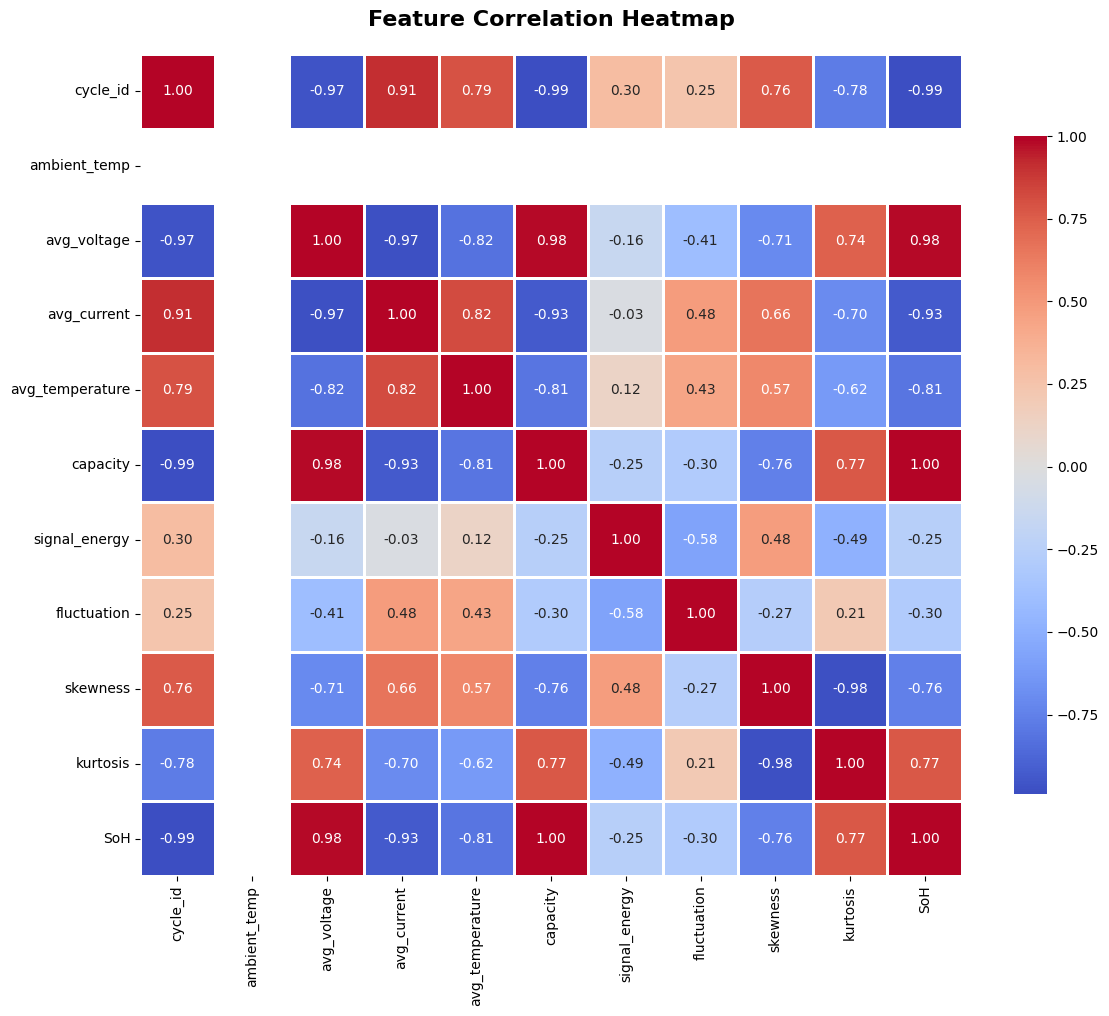

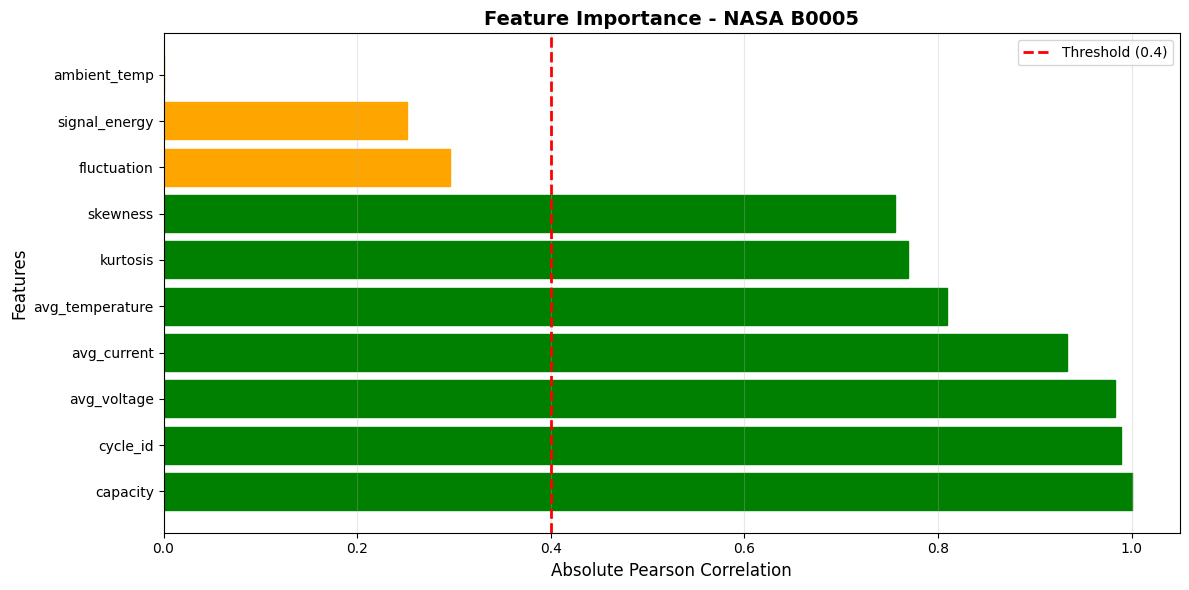


[3/7] Splitting data...

[4/7] Preparing sequences...

[5/7] Training GRU-MHA model...

Model Summary:


Model: "GRU_MHA_Model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ correlated_input    │ (None, 1, 7)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ uncorrelated_input  │ (None, 1, 3)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_corr_1 (GRU)    │ (None, 1, 4)      │        156 │ correlated_input… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_uncorr_1 (GRU)  │ (None, 1, 4)      │        108 │ uncorrelated_inp… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_corr_2 (GRU)    │ (None, 1, 4)      │        120 │ gru_corr_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_uncorr_2 (GRU)  │ (None, 1, 4)      │        120 │ gru_uncorr_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mha_corr            │ (None, 1, 4)      │        612 │ gru_corr_2[0][0], │
│ (MultiHeadAttentio… │                   │            │ gru_corr_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mha_uncorr          │ (None, 1, 4)      │        612 │ gru_uncorr_2[0][… │
│ (MultiHeadAttentio… │                   │            │ gru_uncorr_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_corr        │ (None, 4)         │          0 │ mha_corr[0][0]    │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_uncorr      │ (None, 4)         │          0 │ mha_uncorr[0][0]  │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concat              │ (None, 8)         │          0 │ flatten_corr[0][… │
│ (Concatenate)       │                   │            │ flatten_uncorr[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 30)        │        270 │ concat[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 15)        │        465 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_dense        │ (None, 1)         │         16 │ dense_2[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dynamic_swish       │ (None, 1)         │          0 │ output_dense[0][… │
│ (DynamicSwish)      │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,479 (9.68 KB)

 Trainable params: 2,479 (9.68 KB)

 Non-trainable params: 0 (0.00 B)


Training model...
Epoch 1/250
5/5 ━━━━━━━━━━━━━━━━━━━━ 16s 305ms/step - loss: 0.4565 - mae: 0.6130 - val_loss: 0.0054 - val_mae: 0.0628 - learning_rate: 0.0010
Epoch 2/250
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.4533 - mae: 0.6103 - val_loss: 0.0050 - val_mae: 0.0594 - learning_rate: 0.0010
Epoch 3/250
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.4487 - mae: 0.6064 - val_loss: 0.0043 - val_mae: 0.0543 - learning_rate: 0.0010
Epoch 4/250
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.4416 - mae: 0.6003 - val_loss: 0.0034 - val_mae: 0.0471 - learning_rate: 0.0010
Epoch 5/250
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.4306 - mae: 0.5908 - val_loss: 0.0023 - val_mae: 0.0385 - learning_rate: 0.0010
Epoch 6/250
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.4137 - mae: 0.5758 - val_loss: 0.0015 - val_mae: 0.0320 - learning_rate: 0.0010
Epoch 7/250
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.3883 - mae: 0.5525 - val_loss: 0.0024 - val_mae: 0.0414 - learning_rate: 0.0010

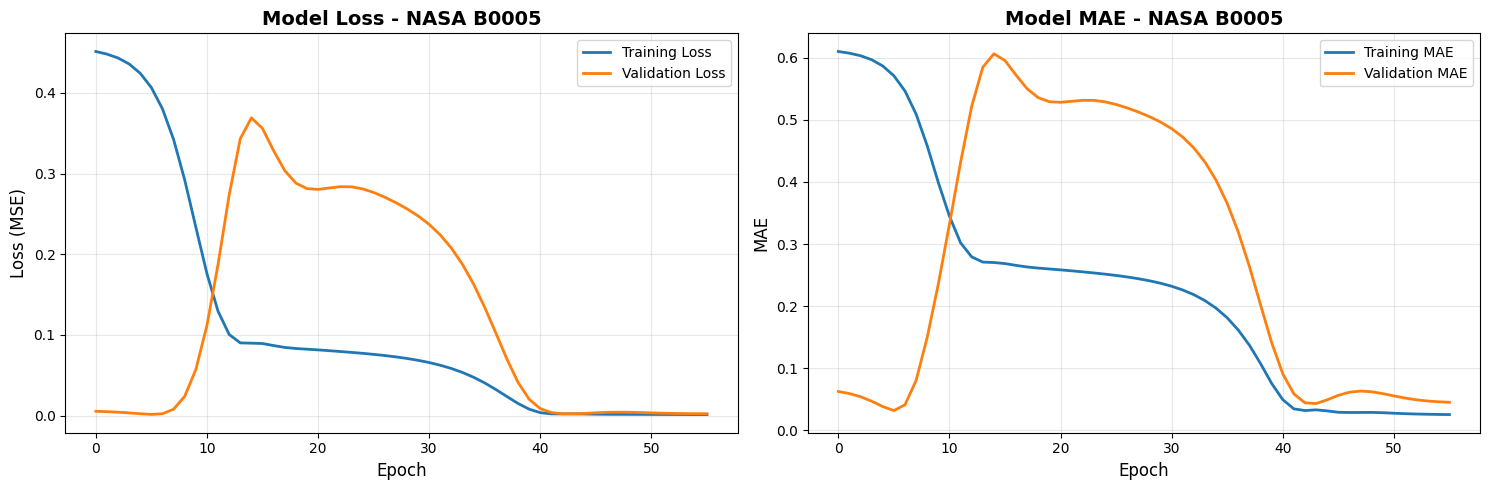


[6/7] Applying Ridge regression...

[7/7] Evaluating model...

Evaluation Results - NASA B0005 - Training
MAE:   0.073083
MSE:   0.006577
RMSE:  0.081096
R² Score: 11.35%


Evaluation Results - NASA B0005 - Testing
MAE:   0.159922
MSE:   0.025721
RMSE:  0.160377
R² Score: -17868.34%



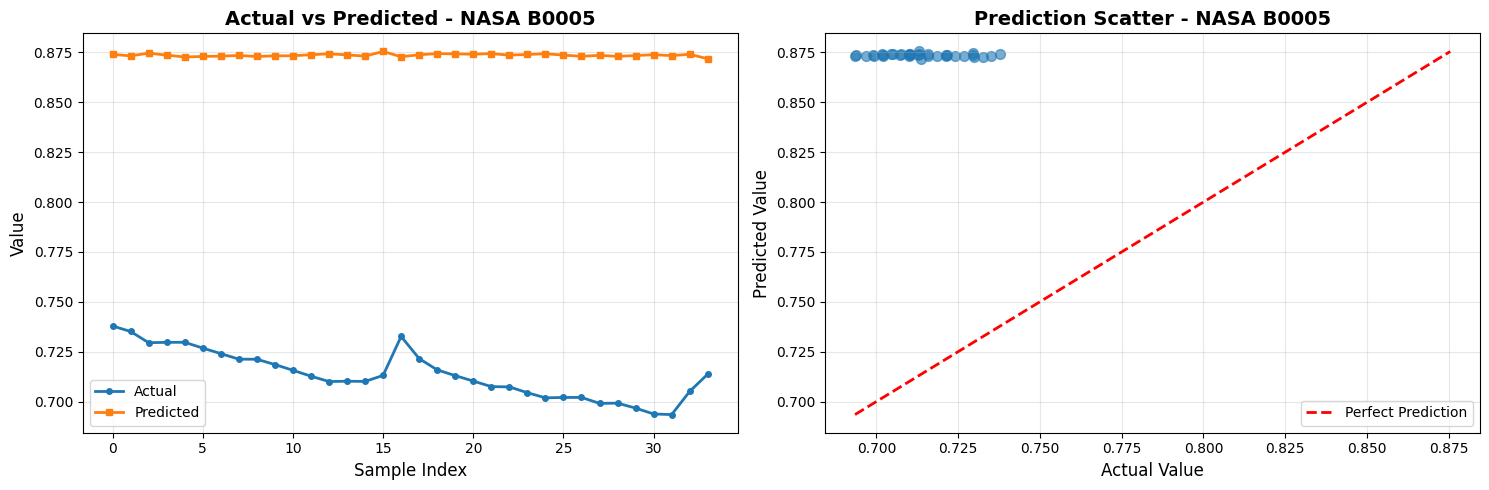

Loading: data/nasa/B0005.mat

Comparing Models on: NASA B0005


KeyError: "None of [Index(['Cycle', 'Time_Measured', 'Voltage_Measured', 'Current_Measured',\n       'Temperature_Measured', 'Capacity', 'Signal_Energy',\n       'Fluctuation_Index', 'Skewness_Index', 'Kurtosis_Index'],\n      dtype='object')] are in the [columns]"

In [ ]:
if __name__ == "__main__":
    print("\nStarting battery RUL/SoH prediction implementation...")
    print("This may take several minutes depending on your hardware.")
    print("\n" + "="*80 + "\n")

    results, comparisons = main()

    print("\n" + "="*80)
    print("EXECUTION COMPLETED SUCCESSFULLY!")
    print("="*80)
    print("\nResults stored in 'results' and 'comparisons' variables")
    print("\nFor real datasets, please:")
    print("1. Update file paths in the code")
    print("2. Uncomment relevant sections in main()")
    print("3. Re-run the notebook")
    print("="*80)

In [ ]:
df = load_nasa_battery("/content/data/nasa/B0005.mat")
print(df.columns)



Loading: /content/data/nasa/B0005.mat
Loaded 0 cycles. Columns: []
RangeIndex(start=0, stop=0, step=1)
